<hr style="height: 1px;">
<i>This notebook was authored by the 8.S50x Course Team, Copyright 2022 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

<h1>Project 3 - Deep Learning and the Ising Model</h1>


<a name='section_3_0'></a>
<hr style="height: 1px;">


## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">PROJ3.0 Overview</h2>


<h3>Navigation</h3>

<table style="width:100%">
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_3_1">PROJ3.1 The Lattice Ising Model</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_3_1">PROJ3.1 Checkpoints</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_3_2">PROJ3.2 Modeling the Phase Transition</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_3_2">PROJ3.2 Checkpoints</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_3_3">PROJ3.3 Constructing Ising Model Simulation</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_3_3">PROJ3.3 Checkpoints</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_3_4">PROJ3.4 NN Application on Triangle Ising Model</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;">Open-Ended Submission</td>
    </tr>
</table>

<h3>Learning Objectives</h3>

In this Project we will explore the following objectives:

- Setting up the canonical 2D Ising Model on a square lattice
- Using a Markov Chain Monte-Carlo Proposal strategy to perform spin-flips
- Simulating a phase transition of the system as a function of temperature
- Implementing a neural network to learn characteristics of the phase transition
- (Open-ended part) Applying the neural network to a triangular lattice and predicting the phase transition




<h3>Importing Libraries</h3>

Before beginning, run the code cells below to import the relevant libraries for this notebook.

In [1]:
#>>>RUN: PROJ3.0-runcell01

!pip install torchmetrics


In [2]:
#>>>RUN: PROJ3.0-runcell02

import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from scipy.sparse import spdiags,linalg,eye
from tqdm import tqdm
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Sampler, BatchSampler, Dataset, DataLoader, Subset, SubsetRandomSampler, random_split
from torchmetrics import Accuracy

<h3>Setting Default Figure Parameters</h3>

The following code cell sets default values for figure parameters.

In [3]:
#>>>RUN: PROJ3.0-runcell03

#set plot resolution
%config InlineBackend.figure_format = 'retina'

#set default figure parameters
plt.rcParams['figure.figsize'] = (6,6)

medium_size = 12
large_size = 15

plt.rc('font', size=medium_size)          # default text sizes
plt.rc('xtick', labelsize=medium_size)    # xtick labels
plt.rc('ytick', labelsize=medium_size)    # ytick labels
plt.rc('legend', fontsize=medium_size)    # legend
plt.rc('axes', titlesize=large_size)      # axes title
plt.rc('axes', labelsize=large_size)      # x and y labels
plt.rc('figure', titlesize=large_size)    # figure title


<a name='section_3_1'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">PROJ3.1 The Lattice Ising Model</h2>    

| [Top](#section_3_0) | [Previous Section](#section_3_0) | [Checkpoints](#problems_3_1) | [Next Section](#section_3_2) |


<h3>Overview</h3>

No numerical physics class would be complete without exploring the Ising model, a mathematical model used to describe the behavior of a collection of interacting magnetic moments such as atoms in a solid or spins in a lattice. It is named after Ernst Ising, a physicist who first proposed it in 1925.

However, because we want use state of the art techniques for this, we are going to study the Ising model using Deep learning. The first part of this project will largely follow work done in <a href="https://arxiv.org/abs/1605.01735" target="_blank">this</a> nature paper:

>source: https://arxiv.org/abs/1605.01735 <br>
>attribution: Juan Carrasquilla, Roger G. Melko (2016), arXiv:1605.01735 [cond-mat.str-el]

This article captures much of the core ideas that we will use for building simulators, and also highlights the basic scheme relevant to the Ising model.

Our first step is to setup the Ising model.


<h3>Setting up Model</h3>

In the Ising model, each magnetic moment is represented by a spin variable $\sigma$, which can take on values of $\pm 1$. The model assumes that these spins interact only with their nearest neighbors in a lattice, and also with an external magnetic field if one is present.

The Hamiltonian of the Ising model describing the energy of a system of spins $\sigma_{i}$ is given by:

$$
H = -J \sum_{i,j} \sigma_{i} \sigma_{j} - \mu_{b} \sum_{j} B_{j} \sigma_{j}
$$

where $J$ is the exchange interaction strength between neighboring spins, $\mu_{b}$ is the magnetic moment of the objects, and $B_{j}$ is the strength of the external magnetic field at the location of particle $j$. The second sum is taken over all spins in the system, while the first one includes only $(i,j)$ pairs which are nearest neighbors on the lattice.

The Ising model exhibits a phase transition, which is a sudden change in the behavior of the system as a parameter is varied. In the absence of an external magnetic field ($B=0$), the model exhibits a phase transition at a critical temperature known as the Curie temperature ($T_C$). Below the critical temperature, the system exhibits long-range ordered spins, with all spins aligning in the same direction, resulting in a net magnetization. Above the critical temperature, the system becomes disordered, with spins pointing in random directions, and the net magnetization vanishes.


The critical behavior of the Ising model at the phase transition is described by universal scaling laws, which are independent of the microscopic details of the system. These scaling laws have been used to study a wide range of physical systems, including magnets, fluids, and even social networks.


As an example of how we will setup the Ising model, see the `initialize` code below, which represents the state of spins on a 2D lattice. Here, we will start with a random initialization. 



In [4]:
#>>>RUN: PROJ3.1-runcell01

def initialize(N):   
    state = 2*np.random.randint(2, size=(N,N))-1
    return state

np.random.seed(20)
N=4
test=initialize(N)
print(test)

[[ 1 -1  1  1]
 [-1 -1  1 -1]
 [ 1 -1  1 -1]
 [-1 -1 -1  1]]


<a name='problems_3_1'></a>     

| [Top](#section_3_0) | [Restart Section](#section_3_1) | [Next Section](#section_3_2) |

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 3.1.1</span>

Now that we have a $4\times4$ lattice of random spins, let's define a Hamiltonian that will output the energy of this system in absence of any external magnetic field.

$$
H = -J \sum_{i,j} \sigma_{i} \sigma_{j}
$$

To make the units simple, set $J=1$.

For this grid, we will use wrap-around (i.e., video-game) coordinates whereby, e.g., the spin at $x=0,\, y=2$ in a $4\times4$ lattice can contribute to the $x=3,\, y=2$ neighbor spin. A mathematical way to summarize this is, for the coordinate $j+1$, $\forall j \geq N ,\, j+1\rightarrow j \mod N$. In this way, a relatively small lattice can effectively simulate what would happen in a much larger system.

Let's give a bit more detail. The function `hamiltonian` will take a lattice of spins as input. The energy of each  spin in the lattice will have contributions from $4$ neighbors. For example, the spin at position `(i,j)` will have one contribution from the spin at poisition `(i, (j+1)%N)`, where the `%N` notation takes care of the wrap-around boundary conditions. Of course, the interaction energy for the other 3 neighbors should be added for the spin at this position. Be sure not to double count!

Complete the code, which should give a value of $4$ for the random seed defined by `np.random.seed(20)` in `PROJ3.1-runcell01` and $\pm8$ for the other two cases listed.


In [5]:
#>>>PROBLEM: PROJ3.1.1
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

def hamiltonian(iArr, N):
    # Calculate nearest neighbors using numpy.roll for periodic boundary conditions
    right_neighbors = np.roll(iArr, -1, axis=1)
    left_neighbors = np.roll(iArr, 1, axis=1)
    up_neighbors = np.roll(iArr, -1, axis=0)
    down_neighbors = np.roll(iArr, 1, axis=0)

    # Sum interactions using vectorized operations
    interaction_sum = iArr * (right_neighbors + left_neighbors + up_neighbors + down_neighbors)
    
    # Calculate the total energy
    energy = -0.5 * np.sum(interaction_sum)
    
    return energy




#TESTS
#-----
N=4

np.random.seed(20)
test1=initialize(N)
print('Test 1')
print(test1)
print('test value =',hamiltonian(test1,N))
print('should be  = 4.0')
print()


np.random.seed(42)
test2=initialize(N)
print('Test 2')
print(test2)
print('test value =',hamiltonian(test2,N))
print('should be  = -8.0')
print()

np.random.seed(4)
test3=initialize(N)
print('Test 3')
print(test3)
print('test value =',hamiltonian(test3,N))
print('should be  = 8.0')
print()

Test 1
[[ 1 -1  1  1]
 [-1 -1  1 -1]
 [ 1 -1  1 -1]
 [-1 -1 -1  1]]
test value = 4.0
should be  = 4.0

Test 2
[[-1  1 -1 -1]
 [-1  1 -1 -1]
 [-1  1 -1 -1]
 [-1 -1  1 -1]]
test value = -8.0
should be  = -8.0

Test 3
[[-1 -1  1  1]
 [ 1 -1  1 -1]
 [-1  1 -1 -1]
 [ 1  1 -1  1]]
test value = 8.0
should be  = 8.0



### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 3.1.2</span>

Now, we would like to come up with a strategy to evolve the spin configurations of the Ising model. To do this we are going to follow a Markov Chain Monte-Carlo Proposal strategy, where we flip the spin at a given lattice site and decide whether to accept or reject the flip based on the change in energy and a temperature parameter.

For this, write a Metropolis algorithm for the function `flip` that does the following:

* Takes indices `[i,j]`, the array of spins `iArr`, the array size `N`, and the parameter `Beta` as inputs. Note, the indices that are given can also be numpy arrays, not just singular values.
* Considers the spin state (or states) of the `[i,j]`-th element(s) of the grid `iArr`.
* Computes the change in energy for a particular element if it were flipped, i.e.: $\Delta H=E_{\rm after}-E_{\rm before}$
* Updates the spin state with acceptance probability $p < e^{\large{-\frac{\Delta H}{k_{b} T} }}$, based on these criteria:

    * If the energy change is negative or zero (the flip would decrease the energy or leave it unchanged), $p=1$.
    * If the energy change is positive (the flip would increase the energy), $p=\exp⁡{−\Delta H \beta}$.
    * For $p<1$, take a random number from a uniform distribution. Update the spin flip if the random number is less than the acceptance probability. Otherwise, do not update the spin flip.


Note that we often define temperature in the Ising model using the parameter $\beta={1}/{k_{b}T}$. Additionally, to make our units extra simple, we will set the Boltzman Constant $k_{b}=1$.

Finally, you will see in the tests below, we will want flip to not just work on single `[i,j]`, but we will want it to work on an array of `[i,j]`. Do all of this in parallel on the array using numpy tools.

We provide several cases that you can use to test your function against expected values. In the solution, we provide a function that prints additional information, to make the actions of this algorithm more apparent.

In [6]:
#>>>PROBLEM: PROJ3.1.2

import numpy as np

def flip(i,j,iArr,N,Beta):
    spin = iArr[i,j]
    energy = 2 * spin * (iArr[i, (j+1)%N] + iArr[i, (j-1)%N] + iArr[(i-1)%N,j] + iArr[(i+1)%N,j])
    
    randomdist = np.random.uniform(size=(energy.shape))
    evaluation = np.exp(-1*(energy>0)*energy*TM1)
    iArr[i,j] *= np.where(randomdist < evaluation, -1, 1)
    return


#THE CODE BELOW SHOULD PRODUCE THE OUTCOMES
#THAT ARE INDICATED IN EACH CASE
N=4

#TRIAL 1: FLIP
######
np.random.seed(20)
test1=initialize(N)
TM1 = 0.01
print('TRIAL 1: TM1 =', TM1)
print('Array')
print(test1)
print("Spin State Before Flip [0,0]:",test1[0,0])
flip(0,0,test1,N,TM1)
print("Spin State After Flip [0,0]:",test1[0,0])
print("Summary: This flips automatically because the change in energy is negative.")
print()


#TRIAL 2: FLIP
######
np.random.seed(20)
test2=initialize(N)
TM1 = 0.01
print('TRIAL 2: TM1 =', TM1)
print('Array')
print(test2)
print("Spin State Before Flip [2,1]:",test2[2,1])
flip(2,1,test2,N,TM1)
print("Spin State After Flip [2,1]:",test2[2,1])
print("Summary: This flips automatically because the change in energy is zero.")
print()


#TRIAL 3: FLIP
######
np.random.seed(20)
test3=initialize(N)
TM1 = 0.01
print('TRIAL 3: TM1 =', TM1)
print('Array')
print(test3)
print("Spin State Before Flip [3,1]:",test3[3,1])
flip(3,1,test3,N,TM1)
print("Spin State After Flip [3,1]:",test3[3,1])
print("Summary: This flips because the flip probability was higher than the randomly drawn number.\nHigh temperature makes this more likely.")
print()


#TRIAL 4: FLIP
######
np.random.seed(20)
test4=initialize(N)
TM1 = 1.0
print('TRIAL 4: TM1 =', TM1)
print('Array')
print(test4)
print("Spin State Before Flip [3,1]:",test4[3,1])
flip(3,1,test4,N,TM1)
print("Spin State After Flip [3,1]:",test4[3,1])
print("Summary: This DOES NOT FLIP because the flip probability was lower than the randomly drawn number.\nWe looked at the same spin as Trial 3, but lower temperature (thus lower flip probability).")
print()


#ADDITIONAL TESTS

#TRIAL 5: Two Flips
######
np.random.seed(20)
test5=initialize(N)
TM1 = 0.1
print('TRIAL 5: TM1 =', TM1)
print('Array')
print(test5)
print("Spin States Before Flip [3,1], [1,1] (should be -1 -1):",test5[3,1],test5[1,1])
iarr=np.array([3,1]) #spin i-indices
jarr=np.array([1,1]) #spin j-indices
flip(iarr,jarr,test5,N,0.1)
print("Spin States After Flip [3,1], [1,1] (should be -1 1):",test5[3,1],test5[1,1])
print()


#TRIAL 6: Two Flips
######
np.random.seed(20)
test6=initialize(N)
TM1 = 0.1
print('TRIAL 6: TM1 =', TM1)
print('Array')
print(test6)
print("Spin States Before Flip [1,2], [1,1] (should be 1 -1):",test6[1,2],test6[1,1])
iarr=np.array([1,2]) #spin i-indices
jarr=np.array([1,1]) #spin j-indices
flip(iarr,jarr,test6,N,0.1)
print("Spin States After Flip [3,1], [1,1] (should be 1 1):",test6[1,2],test6[1,1])


TRIAL 1: TM1 = 0.01
Array
[[ 1 -1  1  1]
 [-1 -1  1 -1]
 [ 1 -1  1 -1]
 [-1 -1 -1  1]]
Spin State Before Flip [0,0]: 1
Spin State After Flip [0,0]: -1
Summary: This flips automatically because the change in energy is negative.

TRIAL 2: TM1 = 0.01
Array
[[ 1 -1  1  1]
 [-1 -1  1 -1]
 [ 1 -1  1 -1]
 [-1 -1 -1  1]]
Spin State Before Flip [2,1]: -1
Spin State After Flip [2,1]: 1
Summary: This flips automatically because the change in energy is zero.

TRIAL 3: TM1 = 0.01
Array
[[ 1 -1  1  1]
 [-1 -1  1 -1]
 [ 1 -1  1 -1]
 [-1 -1 -1  1]]
Spin State Before Flip [3,1]: -1
Spin State After Flip [3,1]: 1
Summary: This flips because the flip probability was higher than the randomly drawn number.
High temperature makes this more likely.

TRIAL 4: TM1 = 1.0
Array
[[ 1 -1  1  1]
 [-1 -1  1 -1]
 [ 1 -1  1 -1]
 [-1 -1 -1  1]]
Spin State Before Flip [3,1]: -1
Spin State After Flip [3,1]: -1
Summary: This DOES NOT FLIP because the flip probability was lower than the randomly drawn number.
We looked at 

<h3>Updating Spins with the Checkerboard Pattern</h3>

It's straightforward to decide whether or not to flip a single spin, but how do we update a whole 2D array? One approach would be to flip the spins one-by-one, which is just far too time-consuming. If taking this approach (which you could try), you have to be mindful of randomly choosing spins, in order to avoid any bias.

If we consider updating multiple spins at once, we must also avoid updating adjacent points at the same time, as this would lead to a somewhat inconsistent Hamiltonian update because the Hamiltonian of a single point is dependent on the neighbors. Now, it turns out that random, Poisson updates of multiple spins can produce the right phase transition, but we will take a more effective approach.

**Ultimately, the most robust method is to apply updates in a checkerboard pattern.** A checkerboard pattern aims to update nodes that are NOT adjacent to one another. In this way, we can update the maximum amount of nodes in a single update. See this <a href="https://medium.com/@kherzieandal/the-checkerboard-metropolis-algorithm-explained-1ecdd301d17d" target="_blank">article</a> for more information.

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 3.1.3</span>

Complete the `update_rand` code below to do the following:

1. **Determine Update Subset**: Set `update` to either 0 or 1 depending on whether the current `index` is even or odd. This is used to determine whether to update the "white" or "black" squares of the checkerboard pattern.<br><br>

2. **Create Index Array `ir`**: Create an array `ir` that holds the indices of either the white or black cells in the flattened version of the grid (i.e., treating the `N x N` array as a 1D array).<br><br>

3. **Adjust `ir` for Checkerboard Pattern**: Use a loop to adjust the indices to account for the alternating pattern of rows in a true 2D checkerboard. For each row, ensure that the correct alternating pattern of updates (black or white squares) is applied. The final `ir` array should hold the 1D indices of the cells to be updated.<br><br>

4. **Convert 1D Indices to 2D Coordinates**: Convert the 1D indices in `ir` to the X (row) coordinates and Y (column) coordinates. [Hint: You may find the Python arithmetic operators `%` (discussed previously) and `//` helpful.]<br><br>

5. **Flip the Lattice Sites**: Call the function `flip` is to actually update the lattice at the specified X and Y coordinates.


In [7]:
#>>>PROBLEM: PROJ3.1.3


def update_rand(iArr, N, TM1, index):
    # Determine the update subset (white or black)
    update = index % 2

    # Create index array
    ir = np.zeros(N * N // 2, dtype=int)
    
    # Precompute values outside the loop
    base_indices = np.arange(0, N // 2) * 2

    # Use broadcasting to fill the `ir` array
    for row in range(N):
        start = row * N // 2
        end = (row + 1) * N // 2
        ir[start:end] = (row * N) + base_indices + (update + row) % 2

    # Convert 1D indices to 2D coordinates
    checkerboardsX = ir // N
    checkerboardsY = ir % N

    # Flip the lattice sites
    flip(checkerboardsX, checkerboardsY, iArr, N, TM1)
    return


#THE CODE BELOW SHOULD PRODUCE THE INDICATED OUTCOME
N=4
TM1=1

np.random.seed(20)
test0=initialize(N)
test1=initialize(N)
test2=initialize(N)

###Part 1
update_rand(test1,N,TM1,0)
print('Test 1')
print("Diff After Rand Flip [YOUR CODE]:", test1.flatten() - test0.flatten())
print("Diff After Rand Flip [SHOULD BE]:", '[  0  0 -2  0  0  0 -2  2  0  0 -2  2  2  0  2  0]' )
print()


###Part 2
update_rand(test2,N,TM1,1)
print('Test 2')
print("Diff After Rand Flip [YOUR CODE]:", test2.flatten() - test0.flatten())
print("Diff After Rand Flip [SHOULD BE]:", '[ -2  2  0 -2  2  2  0  0  0  2  0  0  0  0  2 -2 ]' )
print()

###Part 3, combined
update_rand(test1,N,TM1,1)
print('Test 3')
print("Diff After Rand Flip [YOUR CODE]:", test1.flatten() - test0.flatten())
print("Diff After Rand Flip [SHOULD BE]:", '[  0  0 -2  0  0  0 -2  2  0  0 -2  2  2  0  2  0] ' )
print()

Test 1
Diff After Rand Flip [YOUR CODE]: [ 0  0 -2  0  0  0 -2  2  0  0 -2  2  2  0  2  0]
Diff After Rand Flip [SHOULD BE]: [  0  0 -2  0  0  0 -2  2  0  0 -2  2  2  0  2  0]

Test 2
Diff After Rand Flip [YOUR CODE]: [-2  2  0 -2  2  2  0  0  0  2  0  0  0  0  2 -2]
Diff After Rand Flip [SHOULD BE]: [ -2  2  0 -2  2  2  0  0  0  2  0  0  0  0  2 -2 ]

Test 3
Diff After Rand Flip [YOUR CODE]: [ 0  0 -2  0  2  0 -2  2  0  0 -2  2  2  0  0  0]
Diff After Rand Flip [SHOULD BE]: [  0  0 -2  0  0  0 -2  2  0  0 -2  2  2  0  2  0] 



<h3>Visualizing the Simulation</h3>

Finally, we can put it all together by adding a plotting function that allows us to visualize the evolution of spins according to the Ising model. We will make use of the energy and magnetization in the next section.

First, we define the `mapPlot` function, which plots the grid and saves it as images that we can then turn into an animated gif.

Next, we include this plotting functionality into a simulation which does the following:  
  * initializes a random array of spins, then updates the spin states for a number of steps `eqSteps`, which effectively evolves a random configuration to a stable state. This is the usual equilibration stage, we often seen in the markov chain process.  
  * Runs a Markov Chain Monte-Carlo simulation after the equilibration step, which similarly randomly flips spins and accumulates the sum of the energy and magnetization of each state
  * Plots the spin state every 5 steps
  
**Run the code below to define these functions.**


In the questions below, we will set the grid size to $32\times 32$ and explore what the visualization has to offer by varying the tempature from `5` to `0.05`. Consider how the Ising model behaves at different temperatures. Does the visualization show any evidence for a phase transition?

In [8]:
#>>>RUN: PROJ3.1-runcell02

from IPython.display import Image

def mapPlot(ax,fig, iArr, i, N, images):
    plt.cla()
    X, Y = np.meshgrid(range(N), range(N))
    ax.pcolormesh(X, Y, iArr, cmap=plt.cm.RdBu);
    ax.text(0.6, 0.3,'Time=%d'%i,fontdict={'size': 24, 'color':  'red'})#; plt.axis('tight')    
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image  = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)

def runTemp_fig(iT,iN,images,fig,ax,eqSteps=500,mcSteps=100):
    pArr = initialize(iN)         # initialise
    beta=1.0/iT 
    for i in range(eqSteps):         # equilibrate
        update_rand(pArr, iN, beta,i) 
    
    for i in range(mcSteps):
        update_rand(pArr, iN, beta,i)           
        if i % 5 == 0: 
            mapPlot(ax,fig,pArr,i,iN,images)
            

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 3.1.4</span>

In the cell below, define the simulation temperature to be `Temp=5` (this is the default setting). Run the simulation and examine the output (where red and blue rectangles indicate the two spin states). What behavior do you observe? **Try running several times to see a variety of possible outcomes.**

Choose from the following potential observations (select ALL that apply):

A) The system can have a striated pattern, where boundaries form between spins states.

B) The system remains in a single state over time (i.e., all spin up or down).

C) The system is nearly all in the same state, with small local fluctuations.

D) The overall spin state of the system fluctuates between almost all up and almost all down.

E) The spin state appears mostly randomized, but some structure exists.

F) The spin state is always completely randomized and there is no order.


/var/folders/3b/srf3cvtx1418sl6pv5bkm8cc0000gn/T/ipykernel_31865/3937298976.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, iArr, cmap=plt.cm.RdBu);


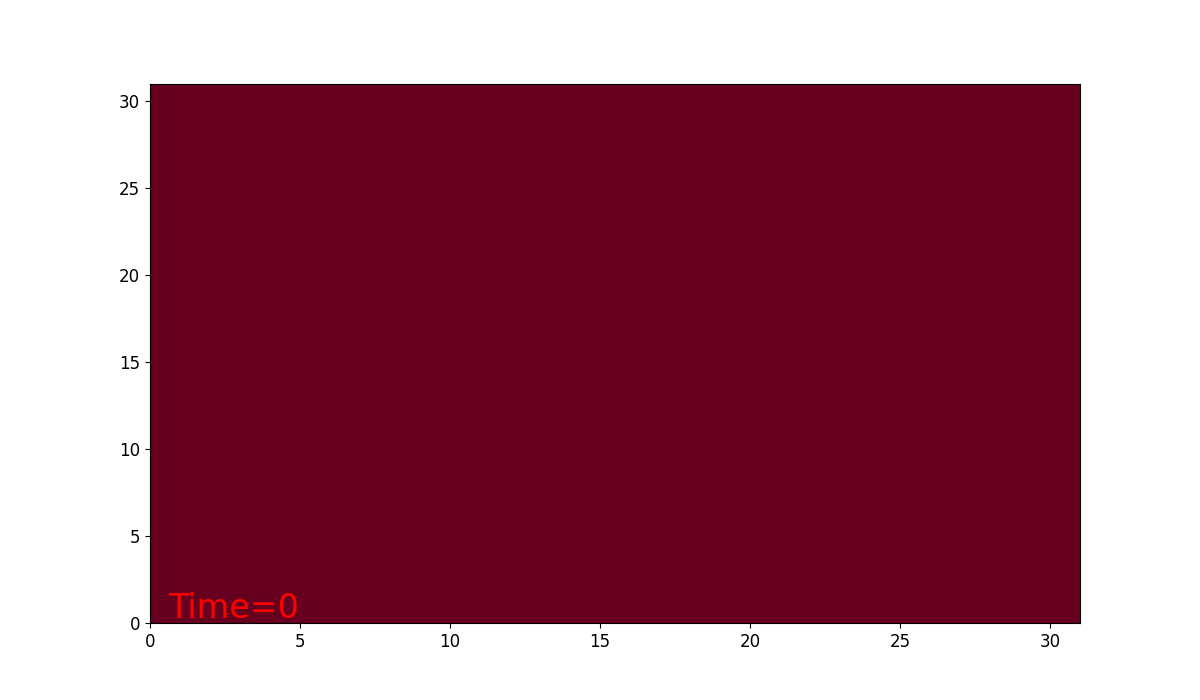

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected 

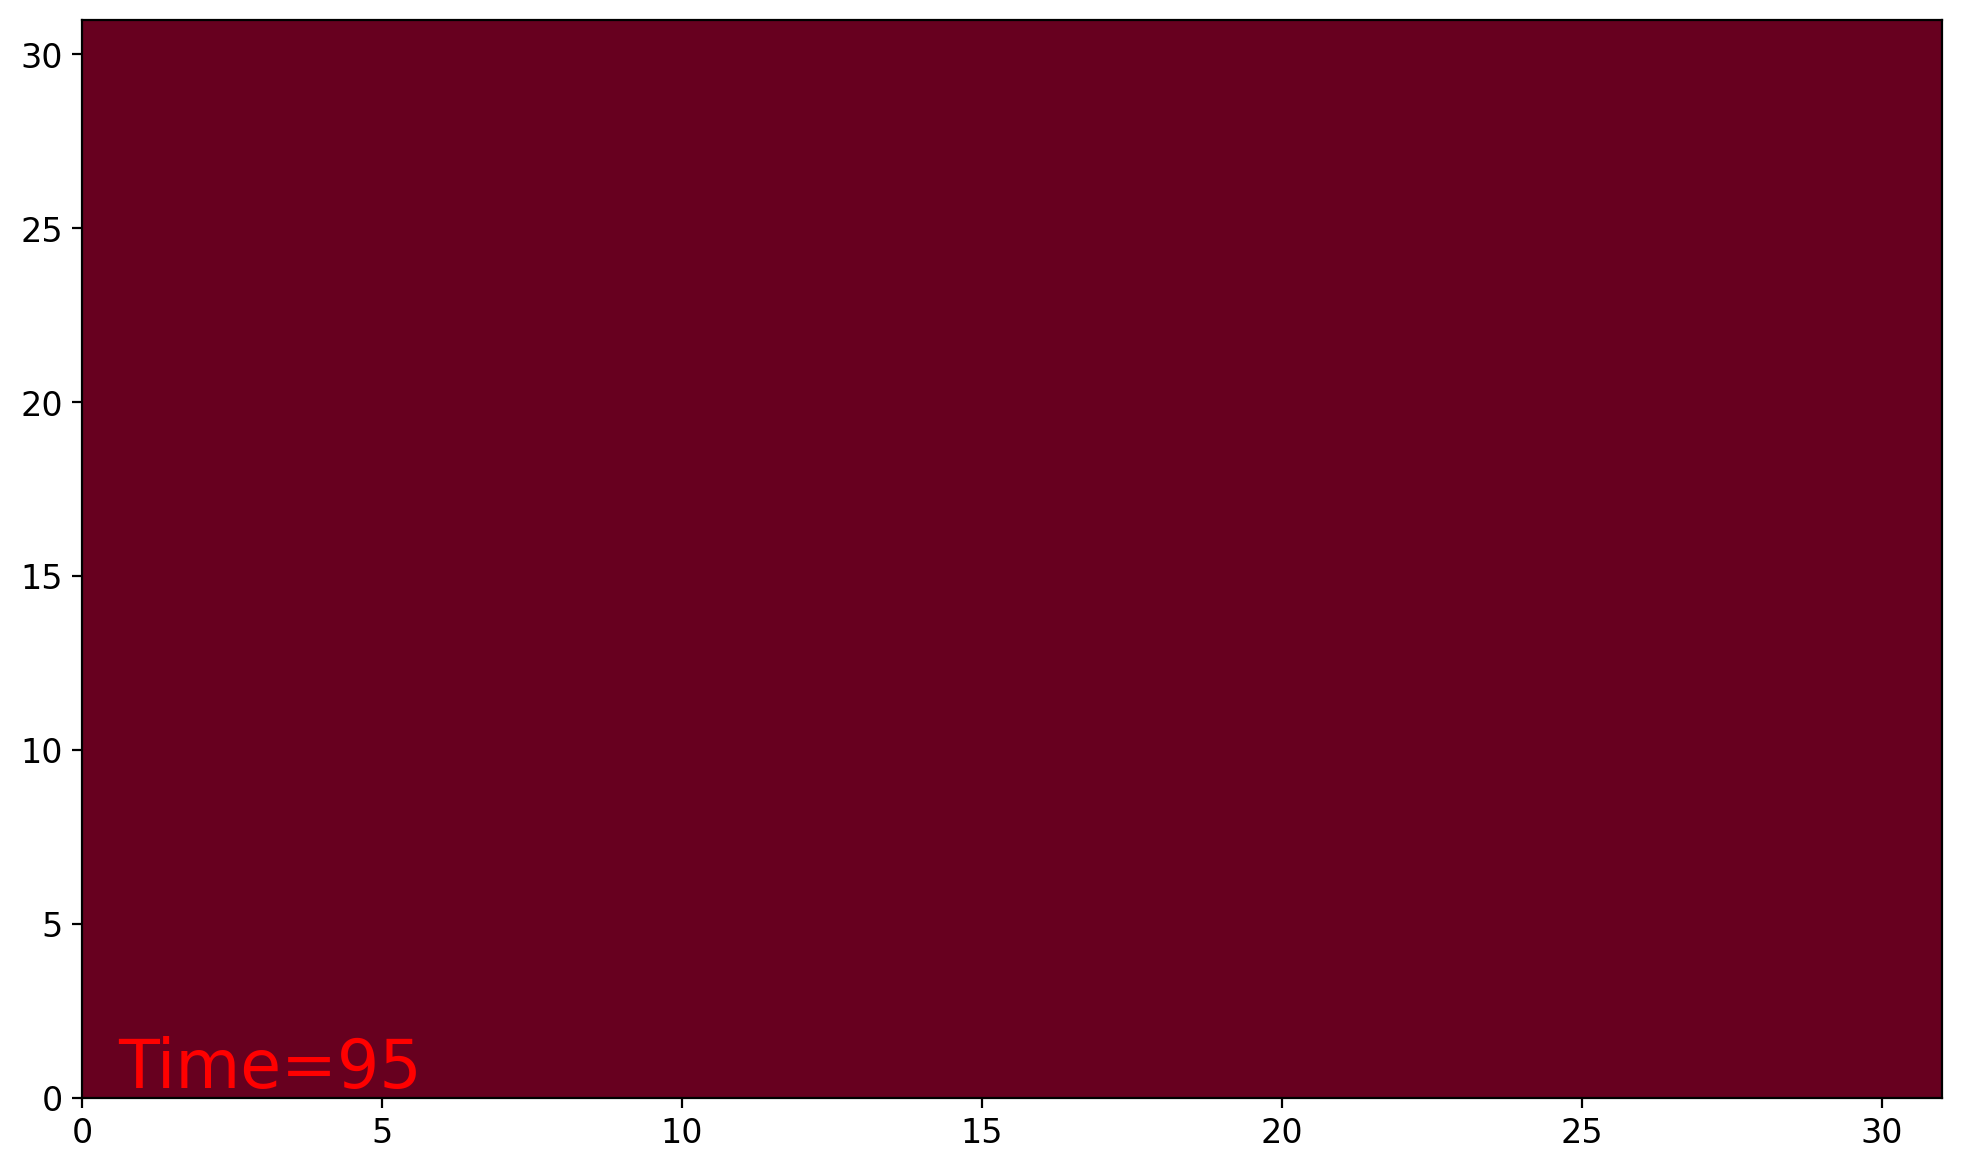

In [9]:
#>>>PROBLEM: PROJ3.1.4
            
images=[]
fig, ax = plt.subplots(figsize=(12,7))

# Modify this line to study different temperatures
Temp=5.

runTemp_fig(Temp,32,images,fig,ax)
imageio.mimsave('./test.gif', images, fps=10, loop=0)
Image(open('test.gif','rb').read())
#Double-click on the gif file in Colab to open

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 3.1.5</span>

Define the simulation temperature to be `Temp=2.5`, then run the simulation and examine the output. **Try running several times to see a variety of possible outcomes.**

Choose from the following potential observations (select ALL that apply):

A) The system can have a striated pattern, where boundaries form between spins states.

B) The system remains in a single state over time (i.e., all spin up or down).

C) The system is nearly all in the same state, with small local fluctuations.

D) The overall spin state of the system fluctuates between almost all up and almost all down.

E) The spin state appears mostly randomized, but some structure exists.

F) The spin state is always completely randomized and there is no order.


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 3.1.6</span>

Define the simulation temperature to be `Temp=1.25`, then run the simulation and examine the output. **Try running several times to see a variety of possible outcomes.**

A) The system can have a striated pattern, where boundaries form between spins states.

B) The system remains in a single state over time (i.e., all spin up or down).

C) The system is nearly all in the same state, with small local fluctuations.

D) The overall spin state of the system fluctuates between almost all up and almost all down.

E) The spin state appears mostly randomized, but some structure exists.

F) The spin state is always completely randomized and there is no order.


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 3.1.7</span>

Define the simulation temperature to be `Temp=0.5`, then run the simulation and examine the output. **Try running several times to see a variety of possible outcomes.**

A) The system can have a striated pattern, where boundaries form between spins states.

B) The system remains in a single state over time (i.e., all spin up or down).

C) The system is nearly all in the same state, with small local fluctuations.

D) The overall spin state of the system fluctuates between almost all up and almost all down.

E) The spin state appears mostly randomized, but some structure exists.

F) The spin state is always completely randomized and there is no order.


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 3.1.8</span>

Define the simulation temperature to be `Temp=0.05`, then run the simulation and examine the output. **Try running several times to see a variety of possible outcomes.**

A) The system can have a striated pattern, where boundaries form between spins states.

B) The system remains in a single state over time (i.e., all spin up or down).

C) The system is nearly all in the same state, with small local fluctuations.

D) The overall spin state of the system fluctuates between almost all up and almost all down.

E) The spin state appears mostly randomized, but some structure exists.

F) The spin state is always completely randomized and there is no order.


<a name='section_3_2'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">PROJ3.2 Modeling the Phase transition</h2>    

| [Top](#section_3_0) | [Previous Section](#section_3_1) | [Checkpoints](#problems_3_2) | [Next Section](#section_3_3) |



<h3>Overview</h3>

With everything that we have developed, we can compute some quantities that characterize the properties of the system. In particular, we would like to compute the following quantities (per spin), where the brackets $\langle \rangle$ represent averages taken over the number of steps in the simulation:

 * Average Energy $\langle E \rangle$
 * Average Magnetization $\langle M \rangle$ (ultimately, we will want to plot $|\langle M \rangle|$)
 * Specific Heat $C=\frac{\langle E^{2}\rangle - \langle E\rangle^{2}}{T^{2}}$ where $\langle E\rangle$ and $\langle E^2\rangle$ are the energy and energy squared, respectively
 * Magnetic Susceptibility $\chi=\frac{\langle M^{2}\rangle - \langle M\rangle^{2}}{T}$ where $\langle M\rangle$ and $\langle M^2\rangle$ are the magnetization and magnetization squared, respectively
 
We can look for sharp changes in the behavior of these quantities as we scan the temperature. Such jumps are indicative of the system going through a phase transition. The specific heat, in particular, has should exhibit a discontinuity right at a phase trasition.

<a name='problems_3_2'></a>     

| [Top](#section_3_0) | [Restart Section](#section_3_2) | [Next Section](#section_3_3) |

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 3.1.3</span>

First let's define a quantity we haven't used yet, the total magnetization of the system. This is just the sum over *all* of the magnetizations due to the spins in the array:

$$
M=\sum_{i\in {\rm Lattice}} \sigma_{i},
$$

Write a function to do this. We have written some checks that calculate the magnetization after applying the `flip` function to different spins, at various temperatures. Your value should match the expected values in these cases.

In [10]:
#>>>PROBLEM: PROJ3.2.1

def mag(iArr):
    return np.sum(iArr)


#THE CODE BELOW SHOULD PRODUCE THE OUTCOMES
#THAT ARE INDICATED IN EACH CASE
N=4

#TRIAL 1
######
np.random.seed(20)
test1=initialize(N)

print('TRIAL 1')
flip(0,0,test1,N,0.01)
print("magnetization:",mag(test1))
print('Should be -4 if you flipped 0,0 correctly')
print()


#TRIAL 2
######
np.random.seed(20)
test2=initialize(N)

print('TRIAL 2')
flip(2,1,test2,N,0.01)
print("magnetization:",mag(test2))
print('Should be 0 if you flipped 2,1 correctly')
print()

#TRIAL 3
######
np.random.seed(20)
test3=initialize(N)

print('TRIAL 3')
flip(3,1,test3,N,0.01)
print("magnetization:",mag(test3))
print('Should be 0 if you flipped 3,1 correctly')
print()


#TRIAL 4
######
np.random.seed(20)
test4=initialize(N)

print('TRIAL 4')
flip(3,1,test4,N,1.0)
print("magnetization:",mag(test4))
print('Should be -2 if you flipped 3,1 correctly')

TRIAL 1
magnetization: -4
Should be -4 if you flipped 0,0 correctly

TRIAL 2
magnetization: 0
Should be 0 if you flipped 2,1 correctly

TRIAL 3
magnetization: -2
Should be 0 if you flipped 3,1 correctly

TRIAL 4
magnetization: -2
Should be -2 if you flipped 3,1 correctly


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 3.2.2</span>

Now modify the function `runTemp` to expicitly output the quatities outlined above: average energy, average magnetization, specific heat, and magnetic susceptibility (where the average is taken over the steps performed in `mcSteps`). Note that these quantities should be normalized by the total number of spins.


In [11]:
#>>>PROBLEM: PROJ3.2.2

def runTemp(iT,iN,eqSteps=500,mcSteps=100):
    pArr = initialize(iN)         # initialise
    E1 = M1 = E2 = M2 = 0 #initial values 
    beta=1.0/iT 
    for i in range(eqSteps):         # equilibrate
        update_rand(pArr, iN, beta,i)   
    
    for i in range(mcSteps):
        update_rand(pArr, iN, beta,i)           
        Ene = hamiltonian(pArr, iN)     # calculate the energy
        Mag = mag(pArr)        # calculate the magnetisation
        
        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag 
        E2 = E2 + Ene*Ene
        
    #compute the values for E,M,C,X here
    navg = 1./(iN**2)
    E = (E1/mcSteps)*navg
    M = (M1/mcSteps)*navg
    C = (E2/mcSteps - (E1/mcSteps)*(E1/mcSteps))*navg*(beta**2)
    X = (M2/mcSteps - (M1/mcSteps)*(M1/mcSteps))*navg*beta
    
    return E,M,C,X


#CHECK ON INITIAL ARRAY
np.random.seed(0)
E,M,C,X = runTemp(1.,32)
#below should print: [-1.8433, -0.2179, 0.0976, 12.5131]
print(list(np.round(np.array([E,M,C,X]),4)))
print()

np.random.seed(20)
E,M,C,X = runTemp(1.,32)
#below should print: [-1.9973, 0.9993, 0.024, 0.0015]
print(list(np.round(np.array([E,M,C,X]),4)))
print()

np.random.seed(20)
E,M,C,X = runTemp(0.01,32)
#below should print: [-2.0, 1.0, 0.0, 0.0]
print(list(np.round(np.array([E,M,C,X]),4)))
print()

[-1.8433, -0.2179, 0.0976, 12.5131]

[-1.9973, 0.9993, 0.024, 0.0015]

[-1.9973, 0.9993, 240.25, 0.1502]



### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 3.2.3</span>

Now, find the values of these quantities as a function of temperature to see if any discontinuous behavior is observed. Complete the code below to make a scan of temperature from about $T = 1.5$ to $3.5$ (units of $J/k_{b}$), then plot the results. The quantity `tqdm` is used to indicate the progress of the computation.

**Note: Averaging over several runs will make things clearer.** Try setting `num_simulations=1` to start, then increase depending on your patience.

Looking at the plots of $E$, $|M|$, $C$, and $\chi$, do you observe any behavior that might be indicative of a phase transition? **What is the critical temperature at which a phase transition occurs?** Enter your answer as a number indicating the approximate temperature where a phase transition occurs, in units of $J/k_{b}$. Use precision `0.5`.

After you have submitted a correct answer, be sure to us the `Show Answer` option. The explanation provides further insight into these topics. There is also plenty of literature about the approximate theoretical value that you should find.

Loading...: 100%|███████████████████████████████| 32/32 [00:25<00:00,  1.27it/s]


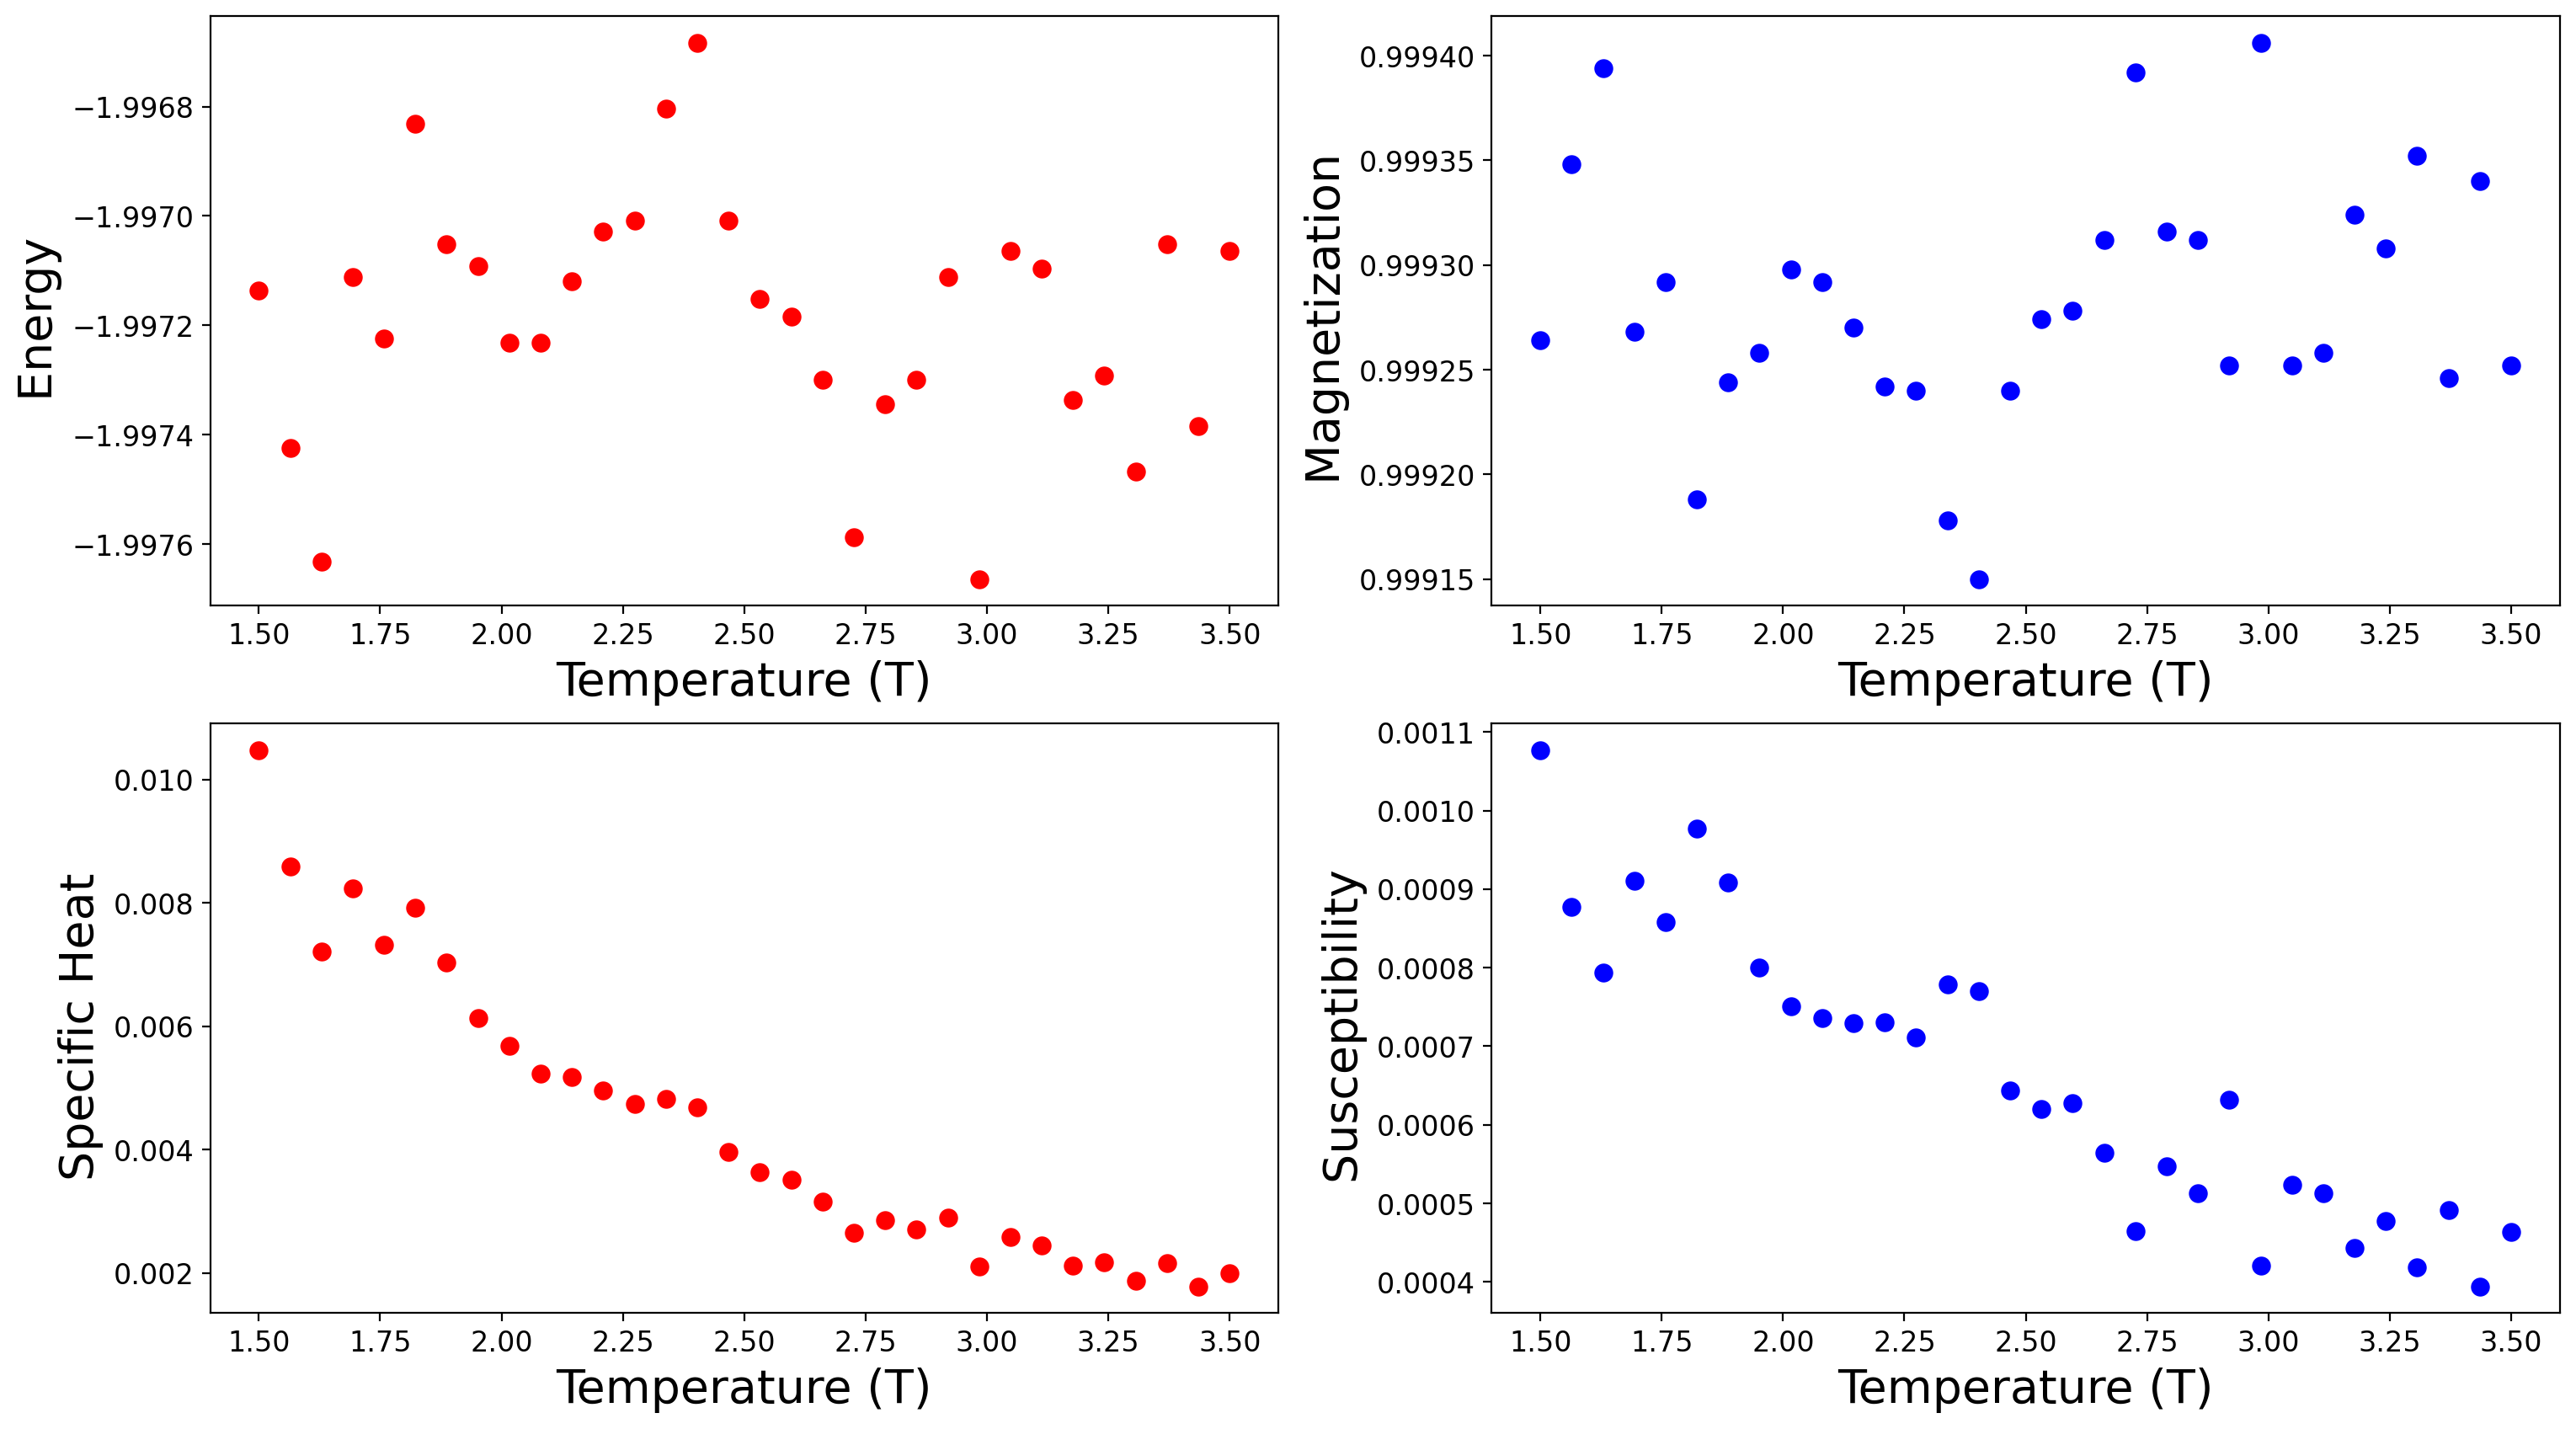

In [12]:
#>>>PROBLEM: PROJ3.2.3

N = 10
nt = 32
num_simulations = 10
T  = np.linspace(1.5,3.5,nt) #again choose wisely

E,M,C,X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)

for temp in tqdm(range(nt), desc="Loading..."):
    E_temp, M_temp, C_temp, X_temp = 0, 0, 0, 0  # Initialize accumulators for averaging

    for _ in range(num_simulations):
        e, m, c, x = runTemp(T[temp], N, eqSteps=1000, mcSteps=1000) #<-change eqSteps and mcSteps if desired
        E_temp += e
        M_temp += np.abs(m) #store the absolute value of the magnetization for each run
        C_temp += c
        X_temp += x

    # Compute the average values and store them
    E[temp] = E_temp / num_simulations
    M[temp] = M_temp / num_simulations
    C[temp] = C_temp / num_simulations
    X[temp] = X_temp / num_simulations
    
f = plt.figure(figsize=(18, 10)); #  

sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T, E, s=50, marker='o', color='red')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);
plt.axis('tight');


sp =  f.add_subplot(2, 2, 2 );
plt.scatter(T, M, s=50, marker='o', color='blue')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Magnetization ", fontsize=20);
plt.axis('tight');

sp =  f.add_subplot(2, 2, 3 );
plt.scatter(T, C, s=50, marker='o', color='red')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Specific Heat ", fontsize=20);
plt.axis('tight');

sp =  f.add_subplot(2, 2, 4 );
plt.scatter(T, X, s=50, marker='o', color='blue')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Susceptibility ", fontsize=20);
plt.axis('tight');

<a name='section_3_3'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">PROJ3.3 Constructing Ising Model Simulation</h2>    

| [Top](#section_3_0) | [Previous Section](#section_3_2) | [Checkpoints](#problems_3_3) | [Next Section](#section_3_4) |

<h3>Training an NN</h3>

Now that we have generated an Ising model, we want to build an optimized scheme to run the Ising model many times so that we can train a neural network to understand the critical temperature for the lattice we are working with.

For this part of the project, we would like to generate Ising Monte Carlo Simulations where we randomly sample many configurations, and we the evolve the configuration at a specific temperature and then save it. Practically, this means we need to make simulated events where in each event we do the following:

- Randomly sample a configutaion<br>
- Evolve that config N steps<br>
- Save the evolved configuration, magnetization, and temperature<br>
- Repeat the above `nsim` times and write this all to disk

Once, we have done that then we can use the datasets have generated to make a neural network that takes as input the random configuration and outputs the temperature.

<a name='problems_3_3'></a>     

| [Top](#section_3_0) | [Restart Section](#section_3_3) | [Next Section](#section_3_4) |

<h3>Generating Ising Configurations</h3>

We will start by making a class that generates Ising configurations. We can use some of the previous functions and what we learned above. **We will provide some unfinished code below and then ask some questions about it.** Let's start with an overview of what it does.

<h3>Overview</h3>

**Initialization (`__init__`)**: `iN` is the size of the 2D lattice (NxN), `Temp` is the temperature of the system, and the lattice (`self.arr`) is initialized with random spins. The arrays to store energy (`E`), magnetization (`M`), specific heat (`C`), and susceptibility (`X`) are initialized.

**`initialize()`**: Generates a random NxN array of spins, with values of either `-1` or `1`, as defined previously in this notebook.

**`simulate()`**: Runs the simulation for a defined number of steps (`self.steps`). In each step, the lattice is updated using the `update_rand` function, which applies the Metropolis-Hastings algorithm to flip spins. The energy and magnetization are calculated at each step, and the specific heat (`C`) and susceptibility (`X`) are also calculated.

**`simulate_save()`**: Runs multiple simulations (`self.nsim` times) and saves the final spin configurations and magnetization to an HDF5 file. The simulation results are stored in datasets within the file, labeled by temperature.

**`lastAvg()`**: Computes the average energy, magnetization, specific heat, and susceptibility over the last 500 steps of the simulation.

**`plotEvol()`**: Plots the evolution of energy, magnetization, specific heat, and susceptibility over the simulation steps.

Energy: -1.6552734375 Magnetization: -0.05712890625 Specific Heat: 0.006564777202672199 Susceptibility: 0.00025620460510253904
Energy: -1.99609375 Magnetization: 0.9990234375 Specific Heat: 0.001465489919347884 Susceptibility: 0.018072816184143616


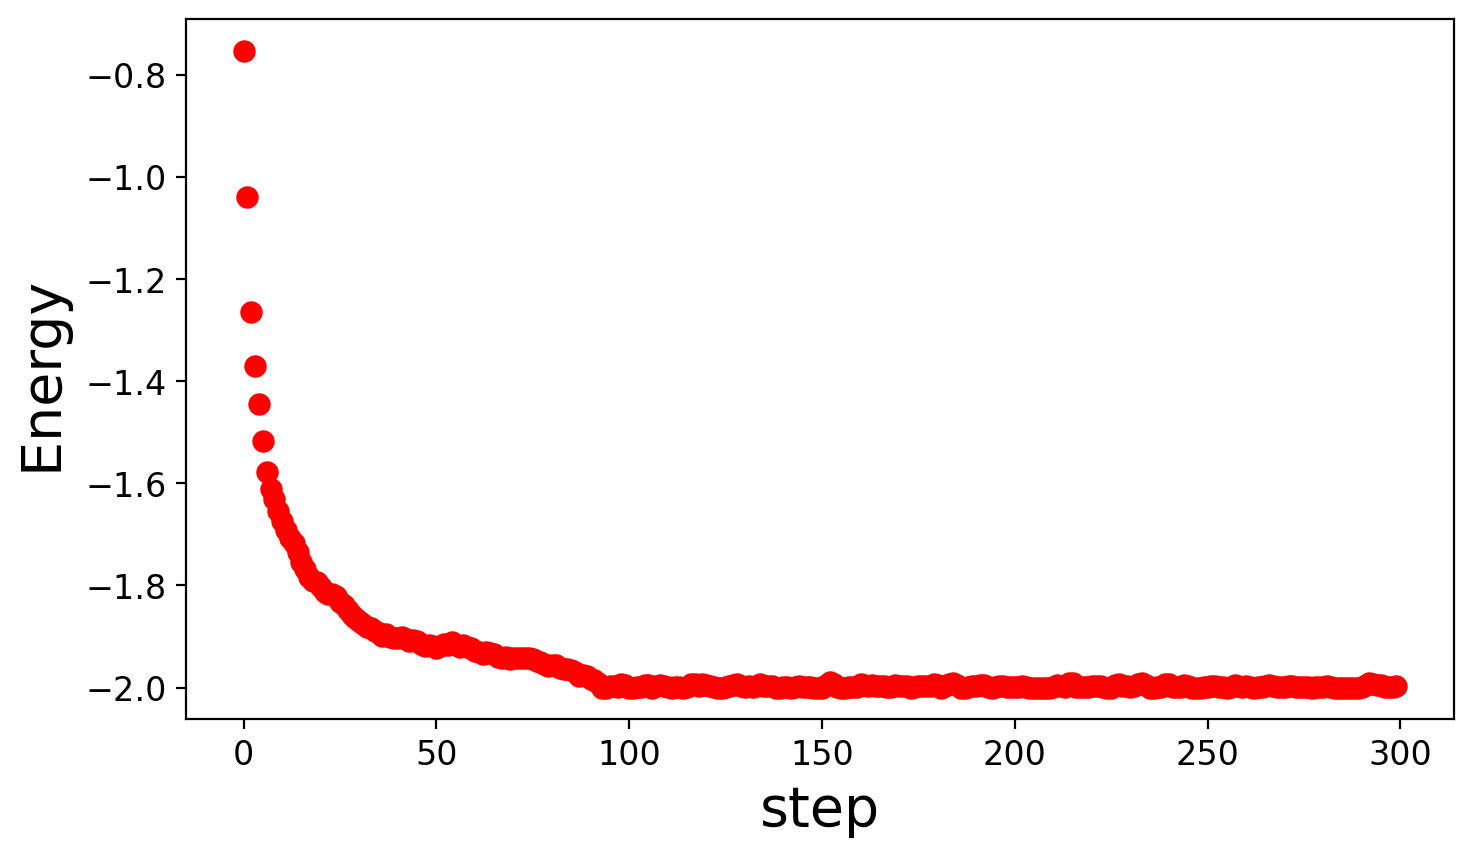

In [34]:
#>>>PROBLEM: PROJ3.3.1 - PROJ3.3.3

#UNFINISHED CODE FOR CHECKPOINTS 3.3.1 - 3.3.3
import h5py 

class Ising():
    
    def __init__(self, iN, Temp, steps=300):
        self.N   = iN
        self.T   = Temp
        self.arr = self.initialize()
        self.steps = steps
        #History over simulatinp
        self.E   = np.array([])
        self.M   = np.array([])
        self.C   = np.array([])
        self.X   = np.array([])
        self.nsim = 1000
        
    def initialize(self):   
        state = 2*np.random.randint(2, size=(self.N,self.N))-1
        return state
    
            
    def simulate(self):
        self.images=[]
        N2M1 = 1./self.N/self.N
        TM1  = 1./self.T
        for i in range(self.steps):
            update_rand(self.arr, self.N, TM1,i)           
            Ene = hamiltonian(self.arr, N)
            Mag = mag(self.arr)
            
            #Now save energy and magnetization
            self.E   = np.append(self.E,Ene*N2M1)
            self.M   = np.append(self.M,Mag*N2M1)

            #Now COMPUTE specific Heat and Magnetic suscpetilibity
            #HINT, consider what the meaning of RMS of Energy and Magnetization are
            #Perhaps consider a sliding window over the last hundred steps
            pC = np.var(self.E)*TM1**2.
            pX  = pX = np. var(self .M)*TM1
            self.C   = np.append(self.C,pC)
            self.X   = np.append(self.X,pX)
            

    def simulate_save(self,pre=''):
        h5f  = h5py.File((pre)+'data_'+str(self.T)+'.h5', 'a')
        data = np.array([])#np.empty((1,self.N,self.N), int)
        mags = np.array([])
        TM1  = 1./self.T
        for n in range(self.nsim):
            if n % 25 == 0:
                print("sim",n)
            self.initialize()
            ## Add code to run simulate the ising model nsteps
            ## update self.arr  

            #for each simulation we want to save the magnetization and the array      
            pMag = mag(self.arr)
            data = np.append(self.arr,data)
            mags  = np.append(pMag,mags)
        #now we write the output array into a dataset
        data = np.reshape(data,(self.nsim,self.N,self.N))
        h5f.create_dataset('data', data=data)
        h5f.create_dataset('mag' , data=mags)
        h5f.close()
                    
    def lastAvg(self):
        avgE = np.mean(self.E[500:-1])
        avgM = np.mean(self.M[500:-1])
        avgC = np.std(self.E[500:-1])
        avgX = np.std(self.M[500:-1])
        return avgE,avgM,avgC,avgX
        
    def plotEvol(self):
        ts = range(len(self.E))
        f = plt.figure(figsize=(18, 10)); #  
        sp =  f.add_subplot(2, 2, 1 );
        plt.scatter(ts, self.E, s=50, marker='o', color='red')
        plt.xlabel("step", fontsize=20);
        plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');

        #PLOT THE ENERGY, MAGNETIZATION (ABSOLUTE VALUE), SPECIFIC HEAT, AND SUSCEPTIBILITY
        

np.random.seed(64)
nsim=10
test = Ising(64,3.4,nsim)
test.simulate()

#PRINT VALUES
print("Energy:",test.E[-1],"Magnetization:",test.M[-1],"Specific Heat:",test.C[-1],"Susceptibility:",test.X[-1])
#test.plotEvol()



np.random.seed(20)
test = Ising(64,3.4)
test.nsim=100
test.simulate()
test.plotEvol()
#PRINT VALUES
print("Energy:",test.E[-1],"Magnetization:",test.M[-1],"Specific Heat:",test.C[-1],"Susceptibility:",test.X[-1])
#test.plotEvol()



### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 3.3.1</span>

In the `simulate()` function above, which of the following options should be used to append the specific heat (`C`) and susceptibility (`X`) at each time step?

A) `pC = np.std(self.E)` and `pX = np.std(self.M)`

B) `pC = np.var(self.E)` and `pX = np.var(self.M)`

C) `pC = np.std(self.E)*TM1**2.`and `pX = np.std(self.M)*TM1`

D) `pC = np.var(self.E)*TM1**2.` and `pX = np.var(self.M)*TM1`

E) `pC = np.std(self.E[-100:])` and `pX = np.std(self.M[-100:])`

F) `pC = np.var(self.E[-100:])` and `pX = np.var(self.M[-100:])`

G) `pC = np.std(self.E[-100:])*TM1**2.` and `pX = np.std(self.M[-100:])*TM1`

H) `pC = np.var(self.E[-100:])*TM1**2.` and `pX = np.var(self.M[-100:])*TM1`



### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 3.3.2</span>

In the `simulate_save()` function, which of the following options should be used to simulate the Ising model steps?


A) `for i in range(self.steps): update_rand(self.arr, self.N, TM1, i)`

B) `for i in range(self.N): update_rand(self.arr, self.steps, TM1, i) ` 

C) `for step in range(self.steps): update_rand(self.arr, self.N, TM1, i)` 

D) `for step in range(self.N): update_rand(self.arr, self.N, TM1, i)` 



### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 3.3.3</span>

Fill in the code above based on your answers to the previous questions, then run the simulation with 10 steps and a fixed seed for N=64, at a temp of 3.4. Print the last value of `E`, `M`, `C`, and `X` (print statement already provided in code). Report the quantities with precision 1e-6.

Note that there is a variability above about which checkerboard pattern to start with. We always start with the top left corner being flipped.  


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 3.3.4</span>

Now complete the `plotEvol()` function in the class `Ising` to plot the energy, magnetization, specific heat, and susceptibility over time. Run the code cell below to generate 100 simulations with `N=64` and `T=3.4`. What features do you observe from the plots? Select ALL that apply:

A) All the plots look completely noisy, with no clear trend.\
B) The effect of equilibration can be seen in some plots, and the quantities begin to settle afterwards.\
C) By the end of the simulation, the quantities no longer fluctuate at all.


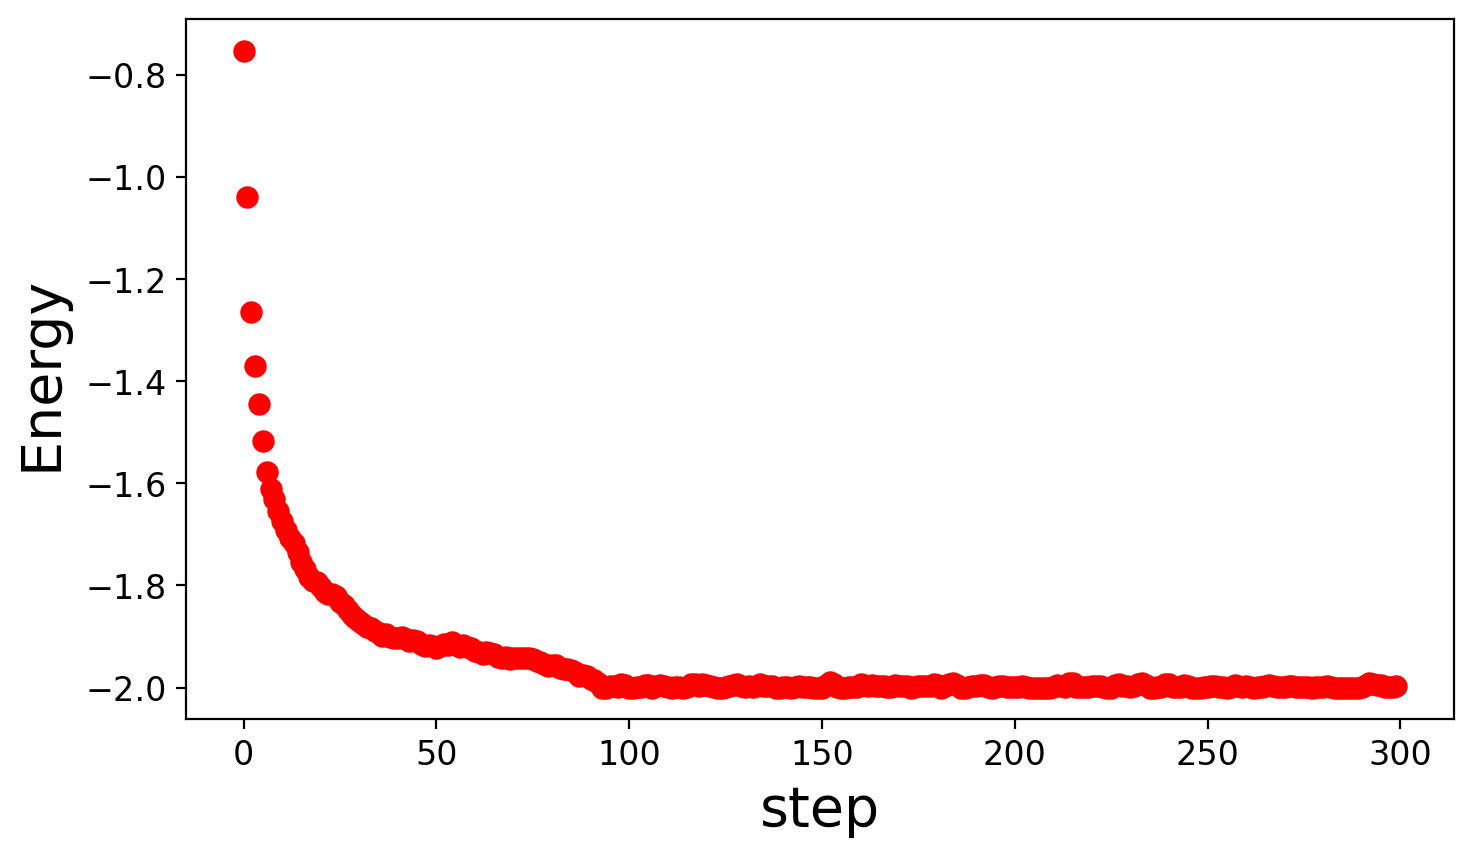

In [14]:
#>>>PROBLEM: PROJ3.3.4

np.random.seed(20)
test = Ising(64,3.4)
test.nsim=100
test.simulate()
test.plotEvol()

<h3>Saving Simulation Data</h3>

Let's save the data from above, where we ran 100 simulations with `N=64` and `T=3.4`. In the code below, we use `simulate_save` so save the data, then open the file and print some features. 


In [16]:
#>>>RUN: PROJ3.3-runcell01

import os

np.random.seed(20)
test = Ising(64,3.4)
test.nsim=100

#write to disk
#os.remove('data_3.4.h5') #first remove file if you need to run again
test.simulate_save()
!ls
print("Lets Look at model")
f = h5py.File('data_3.4.h5', 'r')
print(list(f.keys()))
print(f['data'].shape)

sim 0
sim 25
sim 50
sim 75


ValueError: Unable to create dataset (name already exists)

<h3>Setting Up Torch Dataset</h3>

Now that we have a class to run our Ising model and save things to disk, we can go ahead and generate some samples following the code below. Let's first generate a test sample so that we understand how to train the neural network. For this, we will generate 10 test samples for each point, this shouldn't take too long, and will allow us to setup the neural network. Also, to make our Ising model manageable, lets use a `32x32` grid. 

Before we build the Neural Network, we are going to use Torch Dataset to process and format the data. Setting this up is a little annoying so we will just write the code for this down here, and we will provide a little example of how to read a Torch DataLoaer. 


In [17]:
#>>>RUN: PROJ3.3-runcell02

import os
nt=20
T       = np.round(np.linspace(1.53, 3.28, nt),2)
print(T)
for temp in tqdm (range (nt), desc="Loading..."):
    #Some hacky code to clean up things
    filename='data_'+str(T[temp])+'.h5'
    try:
        os.remove(filename)
    except OSError:
        pass
    test = Ising(32,T[temp])
    test.nsim=500
    test.simulate_save()
    
f = h5py.File('data_1.53.h5', 'r') 
list(f.keys())
f['data'].shape
!ls

[1.53 1.62 1.71 1.81 1.9  1.99 2.08 2.17 2.27 2.36 2.45 2.54 2.64 2.73
 2.82 2.91 3.   3.1  3.19 3.28]


Loading...:  10%|███▏                            | 2/20 [00:00<00:01, 14.07it/s]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475
sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475
sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  20%|██████▍                         | 4/20 [00:00<00:01, 14.71it/s]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475
sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475
sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  40%|████████████▊                   | 8/20 [00:00<00:00, 15.02it/s]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475
sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475
sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475
sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200


Loading...:  60%|██████████████████▌            | 12/20 [00:00<00:00, 14.86it/s]

sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475
sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475
sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475
sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175


Loading...:  70%|█████████████████████▋         | 14/20 [00:00<00:00, 14.87it/s]

sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475
sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475
sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475
sim 0
sim 25
sim 50
sim 75
sim 100


Loading...:  80%|████████████████████████▊      | 16/20 [00:01<00:00, 14.69it/s]

sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475
sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475
sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.66it/s]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475
sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475
8S50x_I3S02.ipynb          8S50x_P04_runcells.ipynb
8S50x_I3S02_runcells.ipynb 8S50x_P05.ipynb
8S50x_L01.ipynb            8S50x_P05_runcells.ipynb
8S50x_L01_runcells.ipynb   8S50x_P06.ipynb
8S50x_L02.ipynb            8S50x_P06_runcells.ipynb
8S50x_L02_runcells.ipynb   8S50x_P07.ipynb
8S50x_L03.ipynb            8S50x_P07_runcells.ipynb
8S50x_L03_runcells.ipynb   8S50x_P08.ipynb
8S50x_L04.ipynb            8S50x_P08_runcells.ipynb
8S50x_L04_runcells.ipynb   8S50x_P09.ipynb
8S50x_L05.ipynb            8S50x_P09_runcells.ipynb
8S50x_L05_runcells.ipynb   8S50x_P10.ipynb
8S50x_L06.ipynb            8S50x_P10_runcells.ipynb
8S50x_L06_runcells.ipynb   8S50x_P11.ipynb
8S50x_L07.ipynb          

<h3>Develop a Neural Network: Part 1</h3>

Now we would like to develop a neural network that will take in this dataset and train for whether the sample has undergone a phase transition (i.e., "learn" the phase transition). To do this, we are going to use binary cross entropy to learn the phase transition with a discrimination below and above the critical time $T_{C}$.

Here is some unfinished code to accomplish the task, and we will ask some questions about it next.

In [24]:
#>>>PROBLEM: PROJ3.3.5 - PROJ3.3.7

class DataSet(Dataset):
    def __init__(self, samples, labels, temps):
        super(DataSet, self).__init__()
        self.labels  = labels
        self.samples = samples
        self.temps   = temps
        if len(samples) != len(labels):
            raise ValueError(
                f"should have the same number of samples({len(samples)}) as there are labels({len(labels)})")
            
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        y = self.labels[index]
        x = self.samples[index]
        t = self.temps[index]
        return x, y, t


#Here is some code to read all the different files and make a dataset
all_data  = None
all_temps = None
for temp in tqdm (range (nt), desc="Loading..."):
    f = h5py.File('data_'+str(T[temp])+'.h5', 'r')
    if temp == 0:
        all_data  = f['data']
        all_temps = np.ones(all_data.shape[0])*temp
    else:
        all_data  = np.append(all_data, f['data'],axis=0)
        all_temps = np.append(all_temps,np.ones(f['data'].shape[0])*temp)

TC = 2.25
nones = nones = len (all_temps [all_temps < TC])
all_data    = np.reshape(all_data,(all_data.shape[0],all_data.shape[1]*all_data.shape[2]))
all_labels  = np.append (np.ones (nones), np. zeros (all_data. shape [0]-nones)).astype ("float32" )
all_dataset = DataSet(samples=all_data.astype("float32"),labels=all_labels,temps=all_temps)

#Finally, we will split the dataset randomly
data_train, data_test = random_split(all_dataset, [int(0.8 * all_data.shape [0]),
len(all_dataset) - int (0.8 * all_data. shape [0]) ])

#And a loader
batch=10
train_loader = DataLoader(data_train, batch_size=batch, shuffle=True)

#here is an example how it works
for count, (x, y, t) in enumerate(train_loader):
    print(count,"x value:",x,x.shape,"\n Label:",y,y.shape,"\n Temp:",t,t.shape)
    if count > 2:
        break
        
print("Total Length:",len(data_train),all_data.shape,len(train_loader))

Loading...: 100%|██████████████████████████████| 20/20 [00:00<00:00, 114.08it/s]


0 x value: tensor([[-1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1., -1., -1.,  ...,  1.,  1., -1.],
        [ 1.,  1., -1.,  ...,  1., -1.,  1.],
        ...,
        [ 1.,  1., -1.,  ...,  1., -1.,  1.],
        [-1.,  1.,  1.,  ...,  1., -1.,  1.],
        [ 1.,  1., -1.,  ...,  1.,  1., -1.]]) torch.Size([10, 1024]) 
 Label: tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]) torch.Size([10]) 
 Temp: tensor([18., 19., 11.,  1., 17.,  4.,  4.,  8.,  7.,  6.], dtype=torch.float64) torch.Size([10])
1 x value: tensor([[-1.,  1.,  1.,  ...,  1., -1., -1.],
        [-1., -1.,  1.,  ..., -1., -1.,  1.],
        [ 1.,  1., -1.,  ...,  1., -1.,  1.],
        ...,
        [ 1.,  1., -1.,  ...,  1., -1.,  1.],
        [ 1., -1., -1.,  ..., -1., -1.,  1.],
        [ 1., -1., -1.,  ..., -1., -1.,  1.]]) torch.Size([10, 1024]) 
 Label: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]) torch.Size([10]) 
 Temp: tensor([ 4., 16.,  8., 15.,  1.,  4., 12.,  8., 17., 17.], dtype=torch.float64) torch.Siz

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 3.3.5</span>

Lets first define the right labels. How do we define a cross entropy label for our dataset if we load our simulated samples and stack them all in temperature order from small to large? Which of the following options should we use to define `all_labels` (and optionally `nones`)? Note, you will have to cast this to a `float32` by using the function `.astype("float32") `

A) `all_labels = np.where(T[temp] < TC, 0, 1).astype("float32")`

B) `nones = len(all_temps[all_temps < TC])` and `all_labels = np.append(np.ones(nones),np.zeros(all_data.shape[0]-nones)).astype("float32")`

C) `all_labels = np.where(all_temps[temp] < 2.25, 0, 1).astype("float32")
`
D) `all_labels = np.random.choice([0, 1], size=(all_data.shape[0],)).astype("float32")`

E) `nones = len(all_temps[all_temps < TC])` and `all_labels = np.append(np.ones(all_data.shape[0]-nones),np.zeros(nones)).astype("float32")`


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 3.3.6</span>

Now let's split our data  into training and testing. Use the `random_split` function from `pytorch` and split it by 80% for training and 20% for testing. Which of the following options will accomplish this?

A) `data_train, data_test = random_split(all_dataset, 0.8, 0.2)`
  
B) `data_train, data_test = random_split(all_dataset, 0.2, 0.8)`

C) `data_train, data_test = random_split(all_dataset, [int(0.2 * all_data.shape[0]), len(all_dataset) - int(0.2 * all_data.shape[0])])`

D) `data_train, data_test = random_split(all_dataset, [int(0.8 * all_data.shape[0]), len(all_dataset) - int(0.8 * all_data.shape[0])])`

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 3.3.7</span>

Ok now let's add a data loader that batches and shuffles the data, for batch of 10. What code should we use? Select the correct option below. Note, view the solution to this problem to see the complete code that combines all answers from the previous few problems.

A) `train_loader=DataLoader(data_train, batch_size=10,shuffle=True)`

B) `train_loader=DataLoader(data_train, batch_size=10)`

C) `train_loader=DataLoader(data_train)`

D) `train_loader=DataLoader(batch_size=10,shuffle=True,data_train)`

E) `train_loader=DataLoader(10,True,data_train)`

<h3>Develop a Neural Network: Part 2</h3>

**First, complete and run the code cell above, related to checkpoints `3.3.5` through `3.3.7`. If needed, you can check our full version of this code in the solution to Checkpoint `3.3.7`.**

Now finally, let's set up a neural network that reads in the inputs, and then trains to find the label. We will create a neural network that takes the input as a vector or image. After you follow the exercises below, you could return and create your own NN here, for instance a Dense network or a CNN. You should try different things!

**As before, we will provide some incomplete code, then help you fill it in with the questions below.**

In [29]:
#>>>PROBLEM: PROJ3.3.8 - PROJ3.3.9

class simple_MLP_4layer(torch.nn.Module):
    def __init__(self,input_size,out_channels=1,nhidden=64):
        super().__init__()
        self-model = nn. Sequential(nn. Linear (input_size, nhidden), nn. ReLU(),nn. Linear (nhidden, nhidden), 
                                    nn. ReLU(),nn. Linear (nhidden, nhidden), nn. ReLU(),
                                    nn. Linear (nhidden, out_channels))
        self.output  = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = self.output(x)
        return x


def train(model,n_epochs=20):
    opt       = torch.optim.Adam(model.parameters(),lr=#YOUR CODE HERE)
    criterion = #### come up with a loss function that is appropriate
    for epoch in range(n_epochs):
        model.train(True)
        running_loss = 0.0; updates=0
        for x, y, t in train_loader:
            opt.zero_grad()
            y_hat = model(x)
            loss  = criterion(y_hat.flatten(),y)
            loss.backward()
            opt.step()
            running_loss += loss
            updates +=1
            del x,y
        print('Epoch: {} LOSS train: {} '.format(epoch,running_loss/(updates*batch)))

model     = simple_MLP_4layer(all_data.shape[1],out_channels=1,act_out=True)
train(model,n_epochs=10)

SyntaxError: cannot assign to expression here. Maybe you meant '==' instead of '='? (1889891038.py, line 6)

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 3.3.8</span>

As a baseline to get you started, define a 4 layer MLP (modify the code above to include that in the `simple_MLP_4layer` class). Which one of the choices of code gives you one layer that can be used to build a 4 layer MLP?

A) `nn.Linear(nhidden, nhidden)` then `nn.ReLU()`
     
B) `nn.Linear(nhidden, nhidden)`

C) `nn.ReLU()`

D) `nn.Sigmoid`


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 3.3.9</span>

Now lets add a loss to the `train` function, that classifies the outputs as being above or below a certain temperature. What criterion should we apply? Select from the options below.

**After completing this part, add you answers to the code cell above and run a training for 10 epochs, with a learning rate `lr < 0.01`. The solution to this problem will contain the full code that we used.**


A) `criterion = nn.MSELoss()`

B) `criterion = nn.CrossEntropyLoss()`

C) `criterion = nn.BCELoss()`

D) `criterion = nn.SmoothL1Loss()`


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 3.3.10</span>

Finally, run the validation below and report the temperature prediction of the neural network! Try running for more epochs if necessary to improve the prediction. What is the value of the predicted critical temperaure, with precision 1e-2?


In [ ]:
#>>>RUN: PROJ3.1-runcell03

model.train(False)
test_accuracy = Accuracy(task="binary", num_classes=2)
tplot  = np.array([])
yplot  = np.zeros(len(T))
ytrue  = np.zeros(len(T))
ycount = np.zeros(len(T))
ypred  = np.array([])
yact   = np.array([])
for x, y, t in train_loader:
    with torch.no_grad():
        y_hat = model(x)
        ypred = np.append(ypred,y_hat)
        yact = np.append(yact,y)
        #tplot = np.append(tplot,t)
        for pT,py_hat,py in zip(t.detach().numpy(),y_hat.detach().numpy(),y.detach().numpy()):
            pT_index = np.where(T==pT)[0][0]
            yplot[pT_index]  += py_hat[0]
            ytrue[pT_index]  += py
            ycount[pT_index] += 1
            
target = torch.tensor(ypred)
preds  = torch.tensor(yact)
print("Accuracy:",test_accuracy(target,preds))
yplot/=ycount
ytrue/=ycount
f = plt.figure(figsize=(9, 5));
f.add_axes([0,0,1,1])#matplotlib.pyplot.figure()
plt.plot(T,yplot, marker='o')
plt.plot(T,ytrue, marker='o')
plt.ylabel('Prediction')
plt.xlabel('Tempareature(T)')
plt.show()

<a name='section_3_4'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">PROJ3.4 NN Application on Triangle Ising Model</h2>    

| [Top](#section_3_0) | [Previous Section](#section_3_3) | [Checkpoints](#problems_3_4) | [Next Section](#section_3_5) |


<h3>Overview</h3>

Once our validation is looking good, we want to show that our neural network has actually learned something non-trivial. For that we want to make a different magnetic field configuration with a different, but similar, Hamiltonian, and see if we can use our neural network to predict the temuprature change. **In particular, we are going to investigate the Triangular Ising Model.**

We can define the Triangular Ising model as a triangular array, as opposed to a square array, like in the picture below: 

<p align="center">
<img alt="triangular lattice" src="https://upload.wikimedia.org/wikipedia/commons/1/15/Tiling_3_simple.svg" width="300"/>
</p>

>source: https://upload.wikimedia.org/wikipedia/commons/1/15/Tiling_3_simple.svg
>attribution: WatchduckYou can name the author as "T. Piesk", "Tilman Piesk" or "Watchduck"., CC BY 4.0 <https://creativecommons.org/licenses/by/4.0>, via Wikimedia Commons


The Hamiltonian is again the Ising Hamiltonian, but now each site has 6 nearest neighbors, so we must sum over all 6 elements $i,j$ connected to a point: 

$$
H = -\frac{1}{2}\sum_{i,j\in{adjacent to i}} \sigma_{i}\sigma_{j} - h \sum_{i} \sigma_{i}
$$

This model for this Hamiltonian was presented in the paper below:

>attribution: Badiev, M.K., Murtazaev, A.K., Ramazanov, M.K. et al. Ground-State Structures of the Ising Model on a Layered Triangular Lattice in a Magnetic Field. J. Exp. Theor. Phys. 134, 644–649 (2022). https://doi.org/10.1134/S1063776122050016

The first term is our usual interaction term, and the second term is the modification of the magnetization in the presence of an external magnetic field $h$. In this case we will set $h$ to zero and solve it when there is no external field. So our Hamiltonian will look like the one below. Note that all this term does is yield a global offset, it can be factorized from the problem. 

$$
H = -\frac{1}{2}\sum_{i,j\in{adjacent to i}} \sigma_{i}\sigma_{j}
$$

<h3>Objective</h3>

Using the Project 3 notebook, apply the neural network that you developed to this new Ising model and determine the phase transition temperature. Additionally, you may extend your investigation to explore other lattice geometries or an external magnetic field ($h\neq0$). Is the NN flexible to a range of possibilities?


<h3>Expectations and Grading</h3>

For this open-ended task, you will be expected to develop some procedure, analyze your results, and present your findings. Specifically, you will do the following:
       
1. Submit a pdf of your work on MITx, to be graded by your peers based on the criteria outlined below.
2. Grade the work of others based on the same criteria.

For full credit on this peer-reviewed checkpoint, we specifically expect you to complete these three tasks (and support your work with thorough explanation:

- Section 1: Define and run a simulation and show that you can predict the transition tempearture. 
- Section 2: Explain your procedure.
- Section 3: Describe your results, characterize the significance, and discuss (i.e., how sure are you that the NN found the right temperature, and what ways can you support your claims?).

<h3>Peer-Evaluation Rubric</h3>

Submit a pdf of your notebook below to MITx Online. Afterwards, you must peer-grade 3 submissions based on the criteria below (your submission will also be graded on these criteria):

<p align="center">
<img alt="project 3 grading rubric" src="https://raw.githubusercontent.com/mitx-8s50/images/main/PROJ3/rubric.png" width="800"/>
</p>

<h3>Section 1: Define and Run the Simulation</h3>

In this section you should do the following steps (and perhaps more that are not explicitly mentioned):

- define a Hamiltonian
- apply a MCMC for performing spin-flips (can you demonstrate that works as expected?)
- run the NN on a dataset for Triangular Ising models
- show that you can predict the correct tempearture (what is it?)

**Begin your work below. You could use the starting code, if you wish.**

In [ ]:
#>>>PROBLEM: PROJ3.4.1

#Now lets define the triangular ising model
def hamiltonian(iArr,N):
    #Compute the hamiltonian (note if you use this function you don't need to redeclare the above class)
    #YOUR CODE HERE
    return energy

def flip(i,j,iArr,N,beta):
    #run the Markov Chain process that computes delta energy, and based on the Markov decision flips the spins.
    #YOUR CODE HERE
    
#Run some checks

In [ ]:
#>>>PROBLEM: PROJ3.4.2

#write code to run some simulations and save neural network output.

In [ ]:
#>>>PROBLEM: PROJ3.4.3

#read the data and output a dataset
def load():
    #YOUR CODE HERE
    return data_tri_train, data_tri_test

data_tri_train, data_tri_test = load()
batch=1000
test_tri_loader = DataLoader(data_tri_test, batch_size=batch,shuffle=True)

#again following above, plot the temp applying your prevoiusly trained NN to the triagle boltzman
model.train(False)
for x, y, t in test_tri_loader:
    with torch.no_grad():

#What is accuracy?
#plot Score vs Temp where is the phase transition, is it consistent with truth? (see arxiv paper)

<h3>Section 2: Explanation of Procedure</h3>

**Explain your code here:**



<h3>Section 3: Explanation of Results and Discussion</h3>

**Describe your results here:**



**Elaborate on some of the additional discussion points below:**

 * Do you see a phase transition?  
 * Does this agree with the paper? 
 * What can you do to make this more accurate?
 
Now there are many follow ups to this study. However, we would like to highlight that he big gains that come from this are not the network itself, its more that the NN has been able to do a visual inspection of a material and make conclusions that are not necessarily obvious. Using this can lead to better analysis of data. Moreover, we can ask ourselves this question: if we can accurately predict properties of materials, can we use this to advance our understanding? 